Training KNN model

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_dataset.csv')
df.head()

,Age,Gender,Heart Rate,Glucose,KCM,Troponin,Output,BP_PC1,BP_PC2
0,0.611111,1.0,0.398810,0.514403,0.126098,0.053659,0.0,0.283868,0.073740
1,0.013889,1.0,0.732143,1.000000,0.548129,1.000000,1.0,-0.414488,0.100240
2,0.486111,1.0,0.375000,0.967078,0.142297,0.009756,0.0,0.223914,0.132454
3,0.611111,1.0,0.446429,0.967078,1.000000,0.590244,1.0,-0.207943,0.131242
4,0.486111,1.0,0.375000,1.000000,0.064711,0.009756,0.0,-0.150425,-0.009916


In [ ]:
X = df.drop('Output', axis=1)
y = df['Output']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training sample: {X_train.shape}, Testing sample: {X_test.shape}")


Training sample: (1056, 8), Testing sample: (265, 8)


In [ ]:
# KNN model

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

y_pred_knn = model_knn.predict(X_test)
classification_report_knn = classification_report(y_test, y_pred_knn)
print("Classification Report (KNN):\n", classification_report_knn)

Classification Report (KNN):
               precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       116
         1.0       0.89      0.86      0.87       149

    accuracy                           0.86       265
   macro avg       0.86      0.86      0.86       265
weighted avg       0.86      0.86      0.86       265



In [ ]:
# Hyperparameter Tuning of KNN model
from sklearn.model_selection import GridSearchCV

print("HYPERPARAMETER TUNING (Grid Search)")
print("="*60)

# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # For minkowski distance
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

HYPERPARAMETER TUNING (Grid Search)
Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameters
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

# Best model
knn_tuned = grid_search.best_estimator_
y_pred_tuned = knn_tuned.predict(X_test)

print(f"\nTuned Model Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Improvement: {(accuracy_score(y_test, y_pred_tuned) - accuracy_score(y_test, y_pred_knn)):.4f}")


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best CV Score: 0.8684

Tuned Model Accuracy: 0.8830
Improvement: 0.0226


In [ ]:
# K-Fold Cross Validation
cv_scores = cross_val_score(knn_tuned, X_train, y_train, cv=10, scoring='accuracy')

print(f"10-Fold CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Std Dev: {cv_scores.std():.4f}")
print(f"95% Confidence Interval: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]")

10-Fold CV Scores: [0.83018868 0.85849057 0.91509434 0.86792453 0.87735849 0.89622642
 0.84761905 0.84761905 0.84761905 0.85714286]
Mean CV Accuracy: 0.8645
Std Dev: 0.0242
95% Confidence Interval: [0.8171, 0.9120]


In [ ]:
# Detailed evaluation matrix

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

# slight changes are observed in report




Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       116
         1.0       0.94      0.85      0.89       149

    accuracy                           0.88       265
   macro avg       0.88      0.89      0.88       265
weighted avg       0.89      0.88      0.88       265



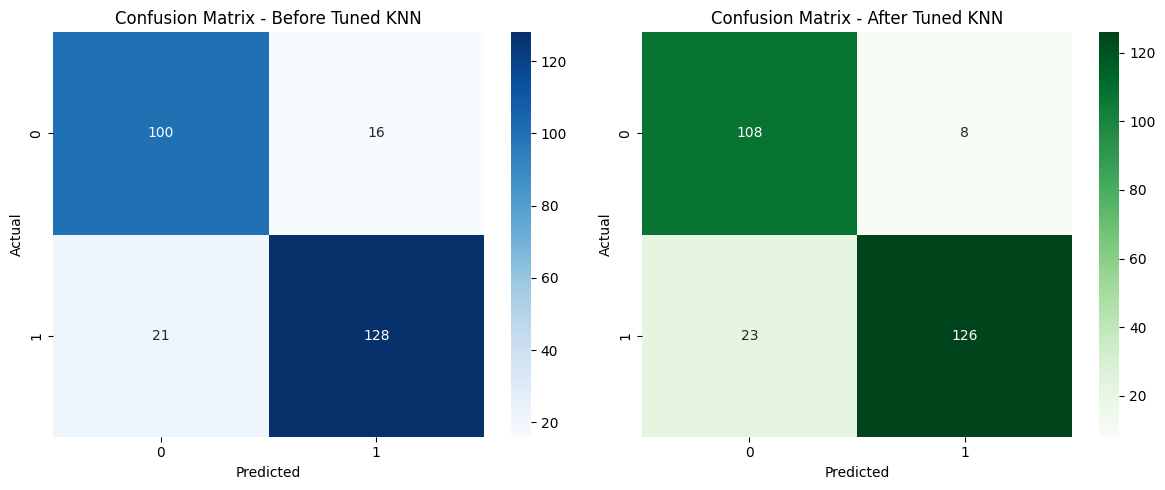

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example confusion matrices
cm_before = confusion_matrix(y_test, y_pred_knn)          # before tuning
cm_after = confusion_matrix(y_test, y_pred_tuned)     # after tuning

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot BEFORE tuning
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Before Tuned KNN')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Plot AFTER tuning
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - After Tuned KNN')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

# Adjust layout and save
plt.tight_layout()
plt.savefig('confusion_matrices_side_by_side.png', dpi=300, bbox_inches='tight')
plt.show()


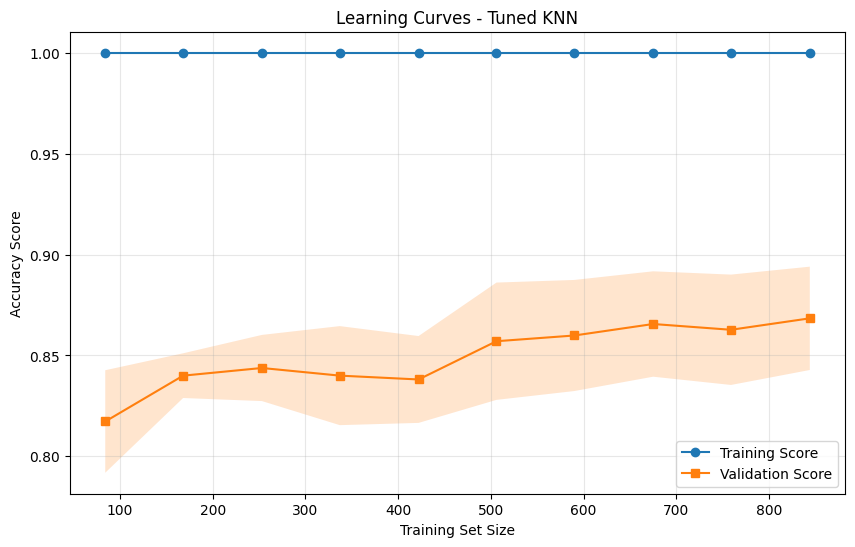

In [ ]:
# learning curve analysis

train_sizes, train_scores, val_scores = learning_curve(
    knn_tuned, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Score', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves - Tuned KNN')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('learning_curves_knn.png', dpi=300, bbox_inches='tight')
plt.show()